In [ ]:
!pip install moviepy


^C


     ---------------------------------------- 0.0/388.3 kB ? eta -:--:--
     -- ---------------------------------- 30.7/388.3 kB 640.0 kB/s eta 0:00:01
     --- --------------------------------- 41.0/388.3 kB 393.8 kB/s eta 0:00:01
     -------- ---------------------------- 92.2/388.3 kB 655.4 kB/s eta 0:00:01
     ----------- ------------------------ 122.9/388.3 kB 654.9 kB/s eta 0:00:01
     ---------------- ------------------- 174.1/388.3 kB 748.1 kB/s eta 0:00:01
     ------------------ ----------------- 204.8/388.3 kB 778.2 kB/s eta 0:00:01
     ----------------------- ------------ 256.0/388.3 kB 785.2 kB/s eta 0:00:01
     ---------------------------- ------- 307.2/388.3 kB 824.9 kB/s eta 0:00:01
     ------------------------------ ----- 327.7/388.3 kB 846.5 kB/s eta 0:00:01
     ------------------------------ ----- 327.7/388.3 kB 846.5 kB/s eta 0:00:01
     ------------------------------ ----- 327.7/388.3 kB 846.5 kB/s eta 0:00:01
     ------------------------------ ----- 327.7

In [ ]:
#Importing the required libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from moviepy import editor

In [ ]:
'''Function that will load the image from the image path and apply preprocessing techniques
specifically converting RGB image to grey image and applying gaussian blur'''
def load_and_preprocess_image(image_path):
    #Loading the image from the image path
    img = cv2.imread(image_path)

    #If image is not found
    if img is None:
        print(f"Could not read {image_path}. Skipping...")
        return None, None

    #Convert the RGB image to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #Applying Gaussian blur to the image
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    #Return the original image with the blurred image
    return img, blurred

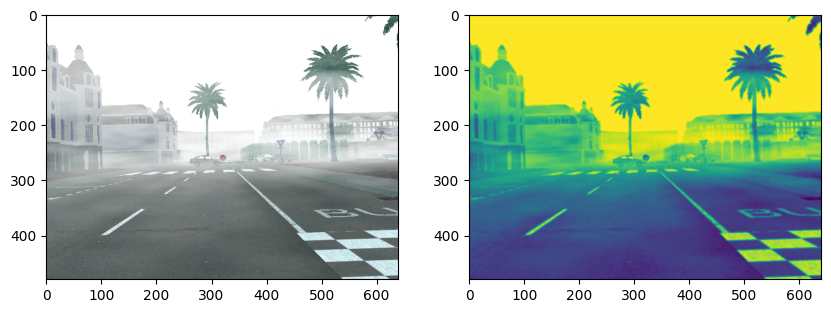

In [ ]:
#Printing the simple and gaussian blur image
img,blurred = load_and_preprocess_image("./Fog/08291278.png")
f, axarr = plt.subplots(1,2, figsize=(10,4))
axarr[0].imshow(img)
axarr[1].imshow(blurred)

In [ ]:
'''Function to determine the region of interest of the image i.e., region where lane detection
needs to be focused. This significantly reduces the computational cost and time of the algorithm'''
def region_of_interest(img):

    #The region of interest of lane detection would be around the vehicle
    #so changing the paramters as per the requirement
    rows, cols = img.shape[:2]
    # A full black image shadowing all the image
    mask = np.zeros_like(img)
    #setting the vertices of the area under focus
    vertice = np.array([[[cols * 0.04, rows * 0.95], [cols * 0.35, rows * 0.62],
     [cols * 0.81, rows * 0.6], [cols * 0.99, rows * 0.96]]], dtype=np.int32)
    #Use to draw polgon of rectangle shape
    cv2.fillPoly(mask, vertice, 255)
    #Combining the mask and normal image to get image that only focuses on certain area
    masked_img = cv2.bitwise_and(img, mask)

    return masked_img

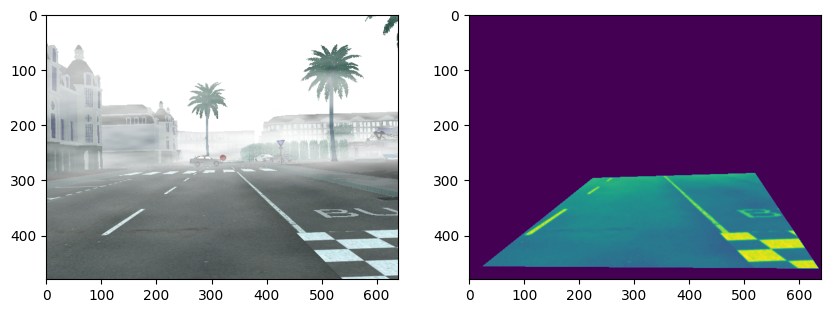

In [ ]:
mask_img = region_of_interest(blurred)
f, axarr = plt.subplots(1,2, figsize=(10,4))
axarr[0].imshow(img)
axarr[1].imshow(mask_img)


In [ ]:
# Applying hough transform on the region of interest
#Developed by Richard Duda and Peter Hart in 1972
def apply_hough_transform(edges, rho=1, theta=np.pi/180,
                          threshold=20, min_line_length=50, max_line_gap=500):
    edges_roi = region_of_interest(edges)
    lines = cv2.HoughLinesP(edges_roi, rho, theta,
                            threshold, np.array([]), minLineLength=min_line_length,
                            maxLineGap=max_line_gap)

    return lines

In [ ]:
lines = apply_hough_transform(mask_img)
lines

array([[[ 67, 422, 595, 403]],

       [[ 96, 399, 587, 391]],

       [[ 46, 439, 633, 460]],

       [[ 59, 429, 619, 439]],

       [[ 52, 434, 629, 454]],

       [[ 75, 416, 592, 398]],

       [[112, 386, 578, 378]],

       [[116, 383, 576, 375]],

       [[ 66, 423, 608, 423]],

       [[163, 346, 561, 353]],

       [[ 94, 401, 588, 392]],

       [[140, 364, 574, 372]],

       [[ 79, 413, 590, 395]],

       [[110, 388, 585, 388]],

       [[189, 325, 555, 344]],

       [[ 62, 426, 617, 436]],

       [[221, 299, 544, 327]],

       [[ 47, 438, 632, 459]],

       [[ 76, 415, 591, 397]],

       [[191, 323, 545, 329]],

       [[159, 349, 563, 356]],

       [[129, 373, 575, 373]],

       [[ 79, 429, 618, 438]],

       [[ 41, 443, 499, 459]],

       [[115, 384, 577, 376]],

       [[ 65, 424, 609, 424]],

       [[148, 358, 565, 358]],

       [[ 64, 425, 616, 435]],

       [[107, 390, 586, 390]],

       [[ 50, 436, 630, 456]],

       [[ 74, 417, 592, 399]],

       [

In [ ]:
'''Function to find the slope and intercept of the lines calculated above'''
def average_slope_intercept(lines):

	left_line = []
	right_line = []
	left_length = []
	right_length = []

	for line in lines:
		for x1, y1, x2, y2 in line:
			if x1 == x2:
				continue
			# Finding slope of a line
			slope = (y2 - y1) / (x2 - x1)


			# Finding intercept of a line
			intercept = y2 - (slope * x2)

			# calculating length of a line by Distance formula
			length = np.sqrt(((x2 - x1) ** 2) + ((y2 - y1) ** 2))

			# slope of left lane is negative and for right lane slope is positive
			if slope > 0:
				right_line.append((slope, intercept))
				right_length.append((length))
			else:
				left_line.append((slope, intercept))
				left_length.append((length))


	left_lane = None

	if(len(left_length))>0:
		left_lane = np.dot(left_length, left_line) / np.sum(left_length)
	else:
		None
	right_lane = None
	if(len(right_length))>0:
		right_lane = np.dot(right_length, right_line) / np.sum(right_length)
	else:
		None
	return left_lane, right_lane

In [ ]:
'''Function that transforms the slope and intercept of a line into pixel coordinates.'''
def pixel_points(point_y1, point_y2, line):
	if line is None:
		return None
	slope, intercept = line
	temp1 = (point_y1 - intercept)
	x1 = int(temp1/slope)
	temp2 = (point_y2 - intercept)
	x2 = int(temp2/slope)
	point_y1 = int(point_y1)
	point_y2 = int(point_y2)
	return ((x1, point_y1), (x2, point_y2))

In [ ]:

'''Function to generate lines using the previously calculated pixel points.'''
def generate_lane_lines(img, lines):
	point_y1 = img.shape[0]
	point_y2 = point_y1 * 0.6
	lf_lane, rt_lane = average_slope_intercept(lines)
	left_line = pixel_points(point_y1, point_y2, lf_lane)
	right_line = pixel_points(point_y1, point_y2, rt_lane)
	return left_line, right_line

In [ ]:
'''Function to visualize the lines on the image.'''
def drawing_annotions(img, lines_calc):
	line_img = np.zeros_like(img) #a blank image created
	for line in lines_calc:
		if line is not None:
			cv2.line(line_img, *line, [0,255,0], 14)
	 #Generate green lines on the blank image.

	#combine both images
	return cv2.addWeighted(img, 1.0, line_img, 2.0, 1.0)


In [ ]:
def test_model_pipeline(img_file):
    img, blur = load_and_preprocess_image(img_file)
    # Adjust the parameters based on specific requirements to observe changes in the resulting image.
    edges = cv2.Canny(blur, 50, 140)
    region = region_of_interest(edges)
    hough = apply_hough_transform(region)
    result = drawing_annotions(img, generate_lane_lines(img, hough))
    return result

Testing the model on 5 random set of images

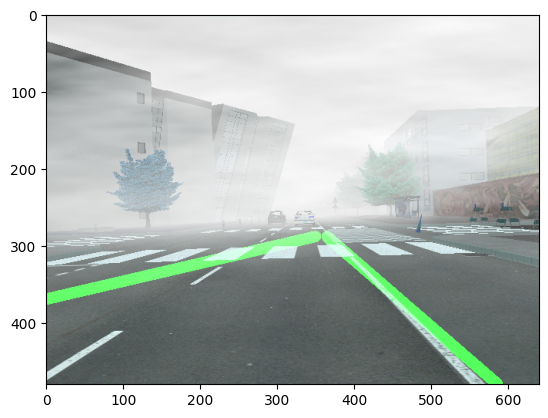

In [ ]:
test1 = test_model_pipeline("./test_images/test1.png")
plt.imshow(test1)
# 9 2 8 1 11

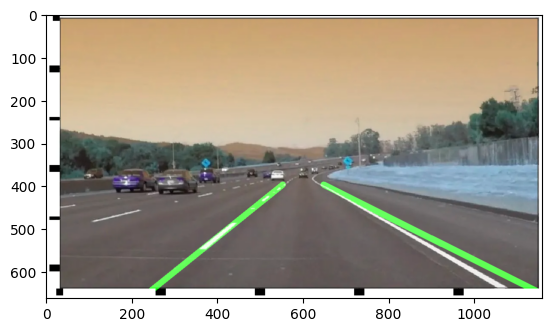

In [ ]:
test2 = test_model_pipeline("./test_images/test2.png")
plt.imshow(test2)

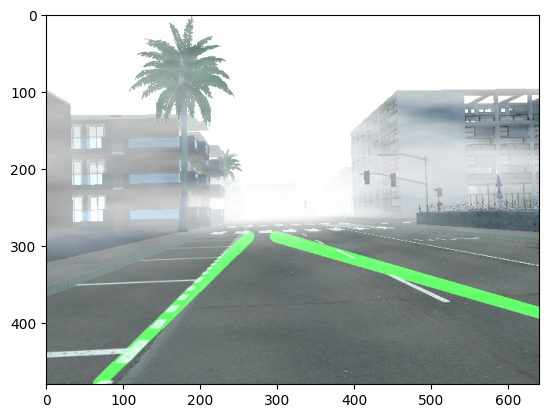

In [ ]:
test3 = test_model_pipeline("./test_images/test3.png")
plt.imshow(test3)

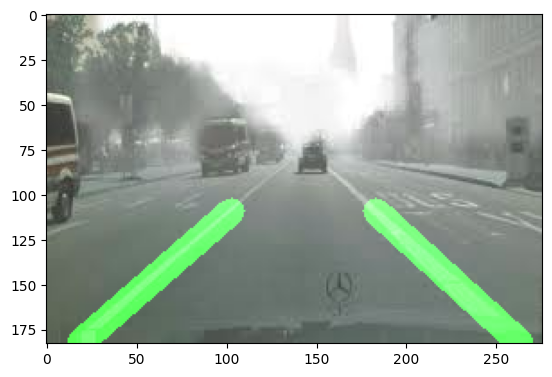

In [ ]:
test4 = test_model_pipeline("./test_images/test4.png")
plt.imshow(test4)

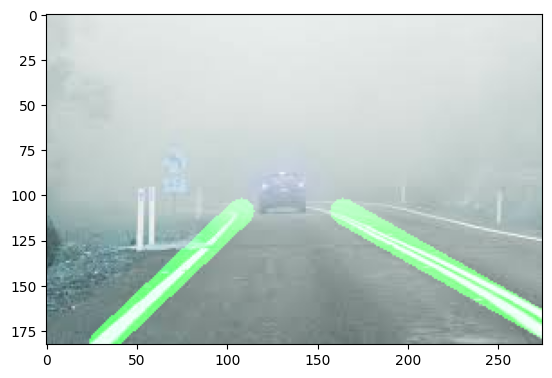

In [ ]:
test5 = test_model_pipeline("./test_images/test5.png")
plt.imshow(test5)

Testing the model on a real-time video

In [ ]:
import moviepy

In [ ]:
def frame_pipeline(image):

    Greyscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(Greyscale_image, (5, 5), 0)
    # Canny edge detector developed by John F. Canny in 1986
    #The resulting image depends on the parameters passed therefore changing the paramters as per requirement
    canny_edges = cv2.Canny(blurred_image, 50, 140)
    region_of_int = region_of_interest(canny_edges)
    hough_image = apply_hough_transform(region_of_int)
    result = drawing_annotions(image, generate_lane_lines(image, hough_image))
    return result

In [ ]:
def process_video(inputvideo, outputvideo):
    input_video = editor.VideoFileClip(inputvideo)
    processed = input_video.fl_image(frame_pipeline)
    processed.write_videofile(outputvideo)

In [ ]:
process_video('./lanes_clip.mp4','result.mp4')

Moviepy - Building video result.mp4.
MoviePy - Writing audio in resultTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video result.mp4



Moviepy - Done !
Moviepy - video ready result.mp4
